In [1]:
import os
import re
import pandas as pd
pd.options.mode.chained_assignment = None 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import category_encoders
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyclustering.cluster.kmedoids as pycluster_kmedoids
import pyclustering.cluster.center_initializer as pycluster_init
import seaborn as sns
import shap
import sklearn.impute
import sklearn.linear_model
import sklearn.metrics
import sklearn.pipeline
import tqdm
import yaml


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Intro

### The dataset
The dataset used in this case study is the dataset, which has been constructed from the Lending Club dataset available on Kaggle. It contains records from over 470,000 peer-to-peer loans issued through the Lending Club platform between June 2012 and August 2015. All loans had a 3-year term, and the outcome of each loan is known (i.e. we know whether it was fully paid or charged off as a loss). The loans issued from April 2015 through August 2015 are designated as the test set.

### The goal of this project
This project seeks to demonstrate the use of Explaonable Machine Learning in a realistic setting. The goal is not to focus on how machine learning techniques can be used to predict the creditworthiness of individual credit applicants, but rather to delve into the ways which explainability techniques can be applied to better understand how ML-based automated creditworthiness decisions are reached.

It should be noted that the authors are not domain experts in credit modeling, and the actual models discussed in the case study may not precisely reflect the best practices of the credit industry. However, the hope is that the models covered do serve as an apt case in which automated decisions have serious impact on the lives of real people, and the predictive information and models used have a degree of sophistication and complexity equivalent to real-world scenarios.

Since the goal of this project does not lie in the exploration of data or the modeling process, we have omitted EDA and model tuning from this notebook.

### The story: creditworthiness modeling
Although peer-to-peer loans are primarily evaluated by human investors, credit models serve as an important tool to help investors choose which loans to fund. Lending Club uses a creditworthiness model to assign a grade to each new application they approve, and they also release their data to allow investors to build their own models. Outside of peer-to-peer lending, credit card companies use creditworthniess models every day to instantly approve or deny applications and generate credit card pre-approvals.

In both peer-to-peer lending and credit card approval, the decisions made using the output of creditworthiness models have significant impact both on credit issuers/investors and on credit applicants. An investor must be comfortable deploying his or her capital behind the output of his or her credit model, and if the model is miscalibrated or buggy, the investor stands to sustain material losses. Similarly, applicants who are refused credit based upon the output of a model can have their lives immediately impacted by the lost opportunity for financial liquidity. Accordingly, government regulation protects credit consumers from potentially unfair credit decisions. For example, the [US Equal Credit Opportunity Act (ECOA)](https://en.wikipedia.org/wiki/Equal_Credit_Opportunity_Act) requires creditors to be able to give the specific reason or reasons why they rejected an application whenever they do so. If such decisions are made by a machine learning system, explainability becomes quite an important component of the automated decision-making process! 


In [2]:
data = pd.read_excel('Lending Club Loans.xlsx')

# Data Filtering (drop missing data)

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
data.head()


,id,loan_amnt,int_rate,sub_grade,emp_length,home_ownership,annual_inc,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,zip_code_prefix
0,36805548,10400,6.99,A3,8 years,MORTGAGE,58000.0,2014-12-01,Charged Off,credit_card,CA,14.92,0,710,714,2,42.0,NaN,17,0,6133,31.6,36,6611.69,5217.75,872.67,0.0,0,59.0,0,0,162110,19400,7,9536,7599.0,41.5,0,0,290,1,1,1,5.0,1.0,42.0,4,6,9,7,18,2,14,32,9,17,0.0,0,0,4,83.3,0,0,179407,15030,13000,11325,937
1,37662224,7650,13.66,C3,< 1 year,RENT,50000.0,2014-12-01,Charged Off,debt_consolidation,AZ,34.81,0,685,689,1,NaN,NaN,11,0,16822,91.9,20,2281.98,704.38,339.61,0.0,0,NaN,0,0,64426,18300,6,5857,332.0,93.2,0,0,148,8,8,0,17.0,3.0,NaN,0,1,4,1,4,12,4,8,4,11,0.0,0,0,2,100.0,0,0,82331,64426,4900,64031,850
2,37822187,9600,13.66,C3,10+ years,RENT,69000.0,2014-12-01,Fully Paid,debt_consolidation,NJ,25.81,0,680,684,0,NaN,NaN,12,0,16388,59.4,44,9973.43,9600.00,373.43,0.0,0,NaN,0,0,38566,27600,8,3214,6494.0,69.2,0,0,265,23,3,0,24.0,17.0,NaN,0,4,7,5,16,17,8,26,7,12,0.0,0,0,3,100.0,0,0,52490,38566,21100,24890,77
3,37741884,2500,11.99,B5,< 1 year,MORTGAGE,89000.0,2014-12-01,Fully Paid,home_improvement,MN,13.77,0,685,689,1,55.0,NaN,9,0,22908,94.3,32,2622.22,2500.00,122.22,0.0,0,NaN,0,0,397223,24300,6,44136,1333.0,86.4,0,0,148,24,6,5,24.0,2.0,NaN,0,3,4,3,6,17,4,10,4,9,0.0,0,0,1,96.8,0,0,415290,61606,9800,47946,554
4,36804663,23325,14.31,C4,10+ years,RENT,72000.0,2014-12-01,Charged Off,credit_card,WA,27.03,1,665,669,0,1.0,NaN,14,0,32372,82.2,23,13907.79,7301.23,3061.64,0.0,0,NaN,0,0,393558,39400,6,39356,3977.0,89.0,0,0,194,15,12,6,23.0,16.0,1.0,0,3,5,7,9,4,10,13,5,14,0.0,0,0,1,95.7,0,0,443889,79490,36000,78126,982


In [4]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

features = data.loc[:, data.columns != 'loan_status']
labels = data.loc[:, data.columns == 'loan_status']

In [5]:
features.head()
drop_features = []
drop_features = features.select_dtypes(['datetime', 'O']).columns.tolist()
drop_features.append('id')
print('Dropping: ', drop_features)
features.drop(columns=drop_features, inplace=True)
features.head()

Dropping:  ['sub_grade', 'emp_length', 'home_ownership', 'issue_d', 'purpose', 'addr_state', 'id']


,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,zip_code_prefix
0,10400,6.99,58000.0,14.92,0,710,714,2,42.0,NaN,17,0,6133,31.6,36,6611.69,5217.75,872.67,0.0,0,59.0,0,0,162110,19400,7,9536,7599.0,41.5,0,0,290,1,1,1,5.0,1.0,42.0,4,6,9,7,18,2,14,32,9,17,0.0,0,0,4,83.3,0,0,179407,15030,13000,11325,937
1,7650,13.66,50000.0,34.81,0,685,689,1,NaN,NaN,11,0,16822,91.9,20,2281.98,704.38,339.61,0.0,0,NaN,0,0,64426,18300,6,5857,332.0,93.2,0,0,148,8,8,0,17.0,3.0,NaN,0,1,4,1,4,12,4,8,4,11,0.0,0,0,2,100.0,0,0,82331,64426,4900,64031,850
2,9600,13.66,69000.0,25.81,0,680,684,0,NaN,NaN,12,0,16388,59.4,44,9973.43,9600.00,373.43,0.0,0,NaN,0,0,38566,27600,8,3214,6494.0,69.2,0,0,265,23,3,0,24.0,17.0,NaN,0,4,7,5,16,17,8,26,7,12,0.0,0,0,3,100.0,0,0,52490,38566,21100,24890,77
3,2500,11.99,89000.0,13.77,0,685,689,1,55.0,NaN,9,0,22908,94.3,32,2622.22,2500.00,122.22,0.0,0,NaN,0,0,397223,24300,6,44136,1333.0,86.4,0,0,148,24,6,5,24.0,2.0,NaN,0,3,4,3,6,17,4,10,4,9,0.0,0,0,1,96.8,0,0,415290,61606,9800,47946,554
4,23325,14.31,72000.0,27.03,1,665,669,0,1.0,NaN,14,0,32372,82.2,23,13907.79,7301.23,3061.64,0.0,0,NaN,0,0,393558,39400,6,39356,3977.0,89.0,0,0,194,15,12,6,23.0,16.0,1.0,0,3,5,7,9,4,10,13,5,14,0.0,0,0,1,95.7,0,0,443889,79490,36000,78126,982


In [6]:
selected_features = ['loan_amnt', 'annual_inc', 'dti', 'fico_range_low', 'acc_open_past_24mths', 'total_il_high_credit_limit']
cleaned_features = features[selected_features]
cleaned_features.head()

,loan_amnt,annual_inc,dti,fico_range_low,acc_open_past_24mths,total_il_high_credit_limit
0,10400,58000.0,14.92,710,7,11325
1,7650,50000.0,34.81,685,6,64031
2,9600,69000.0,25.81,680,8,24890
3,2500,89000.0,13.77,685,6,47946
4,23325,72000.0,27.03,665,6,78126


In [7]:
target = labels['loan_status'].eq('Charged Off').astype('uint8')
print(len(features), len(target))

71118 71118


In [8]:
train_features, test_features, train_target, test_target = train_test_split(cleaned_features, target, test_size=0.35, random_state=0)

train_features.head()

,loan_amnt,annual_inc,dti,fico_range_low,acc_open_past_24mths,total_il_high_credit_limit
69589,12000,82500.0,15.67,685,4,40442
26195,5000,50000.0,23.50,675,4,76590
29225,20950,50000.0,38.77,665,3,51586
16679,5000,52000.0,16.06,685,4,20002
45429,28000,87400.0,24.10,705,4,50711


# Data preprocessing
To get our data into a good format for machine learning, we'll do some fairly standard preprocessing, including imputing missing values, one-hot encoding categorical variables, and applying standard scaling.

In [9]:
class DatasetPreprocessor:
    """Handles NaNs, the encoding of categorical variables, and the rescaling of all variables."""
    def __init__(self):
        self.imputer = None
        self.categorical_encoder = None
        self.scaler = None
    
    def fit(self, features_df):
        # fit categorical encoding
        self.categorical_encoder = category_encoders.OneHotEncoder(
            cols=features_df.select_dtypes('category').columns.tolist(),
            handle_unknown='ignore', use_cat_names=True)
        self.categorical_encoder.fit(features_df)
        df = self.categorical_encoder.transform(features_df)
        
        # fit imputer
        self.imputer = sklearn.impute.SimpleImputer()
        self.imputer.fit(df)
        df[:] = self.imputer.transform(df)
            
        # fit standard scaler
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.scaler.fit(df)
        
    def transform(self, features_df):
        """One-hot encodes categorical variables, imputes missing values, and rescales everything."""
        df = self.categorical_encoder.transform(features_df)
        df[:] = self.imputer.transform(df)
        df[:] = self.scaler.transform(df)
        
        return df

In [10]:
test_features.head()
saved_train_features = train_features.copy()
saved_test_features = test_features.copy()

In [11]:
%%time

preprocessor = DatasetPreprocessor()
preprocessor.fit(train_features)
train_features_processed = preprocessor.transform(train_features)
test_features_processed = preprocessor.transform(test_features)

train_features_processed.head()
test_features_processed.head()


CPU times: user 192 ms, sys: 21.1 ms, total: 213 ms
Wall time: 91.9 ms


,loan_amnt,annual_inc,dti,fico_range_low,acc_open_past_24mths,total_il_high_credit_limit
15937,0.277632,0.670124,0.397736,0.410632,-0.570206,1.409323
26460,-0.099520,0.338693,0.266030,0.410632,0.063797,0.050871
42414,-0.602390,-0.569139,0.389577,2.221126,-0.570206,-0.424365
25574,0.277632,1.102426,-1.491603,-0.576910,-0.570206,-0.669163
44005,-0.350955,-0.122428,0.010777,-0.906091,0.063797,-0.268195


In [12]:
test_features.head()

,loan_amnt,annual_inc,dti,fico_range_low,acc_open_past_24mths,total_il_high_credit_limit
15937,0.277632,0.670124,0.397736,0.410632,-0.570206,1.409323
26460,-0.099520,0.338693,0.266030,0.410632,0.063797,0.050871
42414,-0.602390,-0.569139,0.389577,2.221126,-0.570206,-0.424365
25574,0.277632,1.102426,-1.491603,-0.576910,-0.570206,-0.669163
44005,-0.350955,-0.122428,0.010777,-0.906091,0.063797,-0.268195


In [13]:
train_features.dtypes.apply(lambda x: x.name).value_counts()

float64    6
dtype: int64

In [14]:
train_features_processed.shape[1]

6

In [15]:
train_target.mean()

0.2054904166486393

In [16]:
print(len(train_features_processed))
print(len(train_target))

46226
46226


# Model Building
We fit and tune two types of models in this case study: a simple linear classifier and a more complicated ensemble of tree models. For our linear classifier, we use l2-regularized logistic regression as implemented in the scikit-learn package. For our tree ensemble, We use the LightGBM implementation of gradient-boosted trees. These models will demonstrate the tradeoff between simplicity (which leads to a degree of natural interpretability) and performance, and will also let us see the differences in how post-hoc explanation techniques work on linear and nonlinear models.

We have already tuned the models using a validation split of the data.

In [38]:
%%time
# define logistic regression
logistic_regression = sklearn.linear_model.LogisticRegression(
    C=int(1e5), solver='lbfgs', random_state=0, max_iter=500)

# define boosted trees
boosted_trees = lgb.LGBMClassifier(
    boosting_type='gbdt', class_weight=None,
    colsample_bytree=0.63157894736842102, importance_type='split',
    learning_rate=0.03, max_depth=-1, min_child_samples=668,
    min_child_weight=0.001, min_split_gain=0.0, n_estimators=681,
    n_jobs=-1, num_leaves=28, objective=None, random_state=None,
    reg_alpha=0.0, reg_lambda=0.0, silent=True,
    subsample=0.55789473684210522, subsample_for_bin=200000,
    subsample_freq=5
)

# fit the models
logistic_regression.fit(train_features_processed, train_target)
boosted_trees.fit(train_features_processed, train_target)

CPU times: user 14.2 s, sys: 298 ms, total: 14.5 s
Wall time: 2.12 s


LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.631578947368421, importance_type='split',
               learning_rate=0.03, max_depth=-1, min_child_samples=668,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=681,
               n_jobs=-1, num_leaves=28, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.5578947368421052, subsample_for_bin=200000,
               subsample_freq=5)

In [39]:
# set plotting theme
sns.set_style('darkgrid')
# make figures larger
plt.rc('figure', dpi=100)

# The performance-interpretability tradeoff
Traditionally ML practitioners have characterized a tradeoff between performance and transparency when building models. As we will see, there is a performance cost to using our simpler model, but rather than accepting that we must use the simpler model to maintain explainability, the remainder of the case study will be focused on attacking the problem of providing acceptable explanations to avoid having to make the performance sacrifice.

In [59]:
def roc_curve_graph(true, pred_dict, figsize=(4, 4)):
    """Compute ROC curve and gini score
    
    Based on https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    but without the multi-class stuff.
    """
    plt.figure(figsize=figsize)
    lw = 1.5
    plt.plot([0, 1], [0, 1], lw=lw, linestyle='--', label='Baseline')
    
    for name, pred in pred_dict.items():
        fpr, tpr, _ = sklearn.metrics.roc_curve(true, pred)
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        print('AUC of {} = {}'.format(name, roc_auc))
        gini = 2 * roc_auc - 1
        plt.plot(fpr, tpr, lw=lw, label=f'[Gini = {gini:.3f}] {name}')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) curve')
    plt.legend(loc='lower right', fontsize='x-small')
    plt.show()

*Auc of Boosted Trees* = 0.6542913068185156
*Auc of Logistic Regression* = 0.6521059361008446


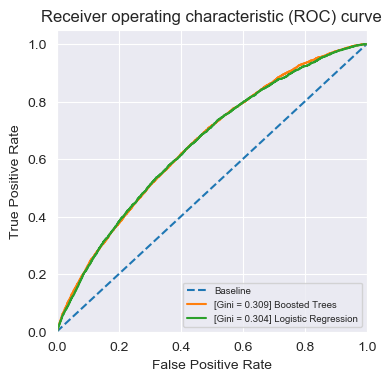

In [60]:
def predict(model, inputs):
    return pd.Series(model.predict_proba(inputs)[:, 1], index=inputs.index)

predictions = pd.DataFrame({
    'Boosted Trees': predict(boosted_trees, test_features_processed),
    'Logistic Regression': predict(logistic_regression, test_features_processed)
})
roc_curve_graph(test_target, predictions)

### Classification Report of Logistic Regression

In [61]:
from sklearn.metrics import classification_report
print(classification_report(test_target, logistic_regression.predict(test_features_processed)))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88     19754
           1       0.32      0.00      0.00      5138

    accuracy                           0.79     24892
   macro avg       0.55      0.50      0.44     24892
weighted avg       0.70      0.79      0.70     24892



### Classification Report of Boosted Trees

In [62]:
from sklearn.metrics import classification_report
print(classification_report(test_target, boosted_trees.predict(test_features_processed)))


              precision    recall  f1-score   support

           0       0.79      1.00      0.88     19754
           1       0.47      0.01      0.02      5138

    accuracy                           0.79     24892
   macro avg       0.63      0.50      0.45     24892
weighted avg       0.73      0.79      0.71     24892



## Performance Analysis
As we can see from the ROC curve and classification report. Boosted Tree has better precision of 73% compared to the precision of Logistic Regression which is 70%. Both of them have similar recall and Boosted Tree has a higher overall weighted F1 score. 

Also, Boosted Tree has a better ROC curve compared to the Logistic Regression. 

# Global interpretability
We can naturally gain some level of interpretability from logistic regression, due to the fact that the model is by construction linear (in terms of the log-odds transform of predicted probability). Since we have taken care to normalize the inputs to unit variance, we can interpret the model coefficients as both the direction and approximate magnitude of impact on final model prediction.

$$log\_odds = w^Tx$$

$$y = 1 / (1 + \exp(-log\_odds))$$

$$w[i] = ?$$

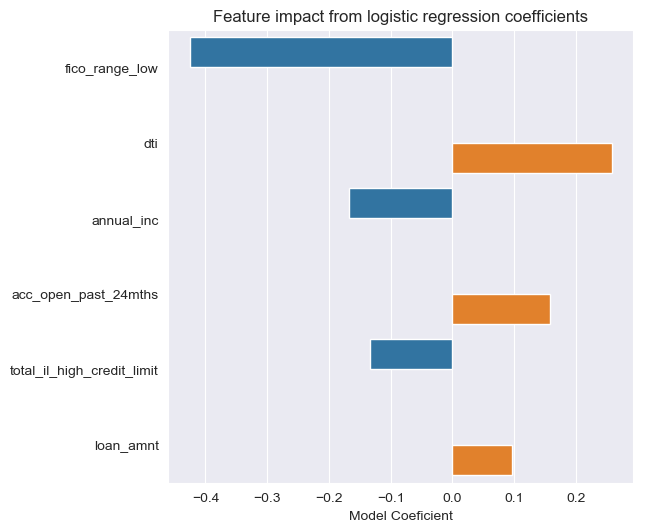

In [63]:
plt.figure(figsize=(6, 6))
logistic_coefficients = pd.Series(
    logistic_regression.coef_[0], index=train_features_processed.columns)
ordered_by_magnitude = logistic_coefficients.abs().sort_values(ascending=False).index
logistic_coefficients = logistic_coefficients[ordered_by_magnitude]
ax = sns.barplot(logistic_coefficients.head(20), 
                 logistic_coefficients.head(20).index, 
                 hue=logistic_coefficients.head(20).apply(np.sign))
ax.get_legend().remove()
plt.title('Feature impact from logistic regression coefficients')
plt.xlabel('Model Coeficient')
plt.show()

### Boosted trees feature importance
There is also some baked-in interpretability in tree ensemble methods, due to the fact that we can track certain measures of feature importance during training.

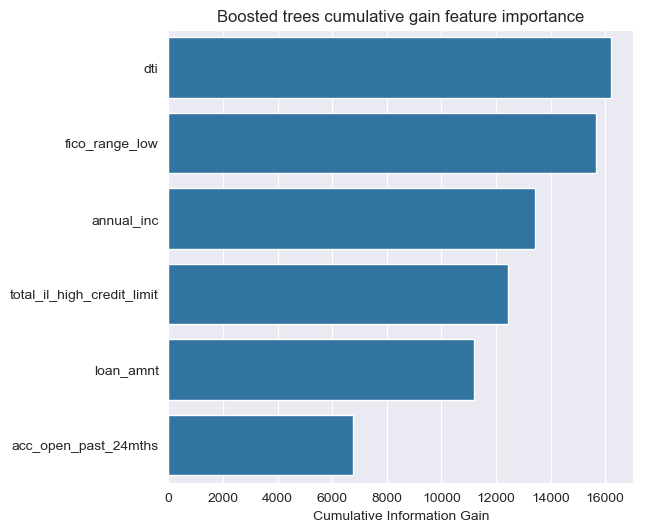

In [64]:
plt.figure(figsize=(6, 6))

boosted_tree_gain = pd.Series(
    boosted_trees.booster_.feature_importance(importance_type='gain'),
    index=train_features_processed.columns)
boosted_tree_gain.sort_values(ascending=False, inplace=True)
ax = sns.barplot(boosted_tree_gain.head(20), 
                 boosted_tree_gain.head(20).index,
                 color=sns.color_palette()[0])
# ax.get_legend().remove()
plt.title('Boosted trees cumulative gain feature importance')
plt.xlabel('Cumulative Information Gain')
plt.show()

## Analysis
As one can see, the top features important for Boosted Tree model globally are Debt-to-Income Ratio and FICO score. And for Logistic Regression FICO score coefficient is higher than DTI. 

Boosted Tree model importance does not give us directionality, where as logistic regression gives directionality. 


# Explaining rejections
We pick a case from our test set where the charged_off_prediction from both models Boosted Tree and Logistic Regression are above a certain threshold (0.2). Since Banks don't generally approve anything beyond 0.2, we want to explain this prediction.  

In [65]:
def get_rejected(model_name, arbitrary_threshold=0.2):
    pred = predictions[model_name]
    is_rejected = pred > arbitrary_threshold
    rejected_index = is_rejected[is_rejected].index
    return rejected_index

both_rejected = list(set(get_rejected('Boosted Trees')).intersection(set(get_rejected('Logistic Regression'))))

In [66]:
np.random.seed(1)
selected_rejections = np.random.choice(both_rejected, 8, replace=False)

In [67]:
rejection_df = pd.concat([test_features.loc[selected_rejections], 
                          predictions.loc[selected_rejections], 
                          test_target.loc[selected_rejections]],
                         axis=1)
rejection_df.rename(columns={'loan_status': 'Loan Charged Off'}, inplace=True)

In [68]:
rejection_df[selected_features + ['Boosted Trees', 'Logistic Regression', 'Loan Charged Off']]

,loan_amnt,annual_inc,dti,fico_range_low,acc_open_past_24mths,total_il_high_credit_limit,Boosted Trees,Logistic Regression,Loan Charged Off
22500,2.163392,0.122543,1.194965,-0.083139,-0.570206,0.473021,0.274340,0.255546,0
53563,-0.350955,-0.525909,-0.336554,-0.741500,-0.570206,-0.956372,0.359979,0.244332,0
25778,-0.099520,1.102426,0.257871,-1.070681,1.648803,3.665638,0.285913,0.206233,0
65261,-0.350955,0.209003,1.326671,-0.083139,0.380798,0.441571,0.292119,0.242850,1
15970,-0.413814,-0.597959,0.713597,0.246042,-0.253205,-0.328868,0.278401,0.213349,0
1733,-0.853825,-0.177618,0.016605,-1.070681,0.380798,-0.481974,0.256409,0.285605,0
60090,-0.696678,-0.684420,0.966519,0.246042,-0.253205,-0.327096,0.320621,0.222292,0
30843,1.258227,0.554844,0.666976,0.081451,1.014801,0.335615,0.210351,0.237508,1


In [69]:
def sigmoid(x):
    """Logistic regression activation function"""
    return 1. / (1. + np.exp(-x))

def sorted_by_abs(x, ascending=True):
    return x[x.abs().sort_values(ascending=ascending).index]

intercept = logistic_regression.intercept_[0]
coef = logistic_regression.coef_[0]
base_pred = sigmoid(intercept)

def explained_lr_inference(inputs):
    log_odds_contributions = sorted_by_abs(coef * inputs, ascending=False)
    log_odds_adj = log_odds_contributions.sum()
    log_odds = intercept + log_odds_adj
    prediction = sigmoid(log_odds)
    return log_odds_contributions, log_odds_adj, log_odds, prediction

In [70]:
rejected_example_id = selected_rejections[0]
example_features = saved_test_features.loc[rejected_example_id]
saved_test_features.head()

,loan_amnt,annual_inc,dti,fico_range_low,acc_open_past_24mths,total_il_high_credit_limit
15937,15000,120000.0,21.71,705,3,98842
26460,12000,97000.0,20.58,705,5,42084
42414,8000,34000.0,21.64,760,3,22228
25574,15000,150000.0,5.50,675,3,12000
44005,10000,65000.0,18.39,665,5,28753


In [71]:
rejected_example_id = selected_rejections[0]
example_features = saved_test_features.loc[rejected_example_id]
model_inputs = test_features_processed.loc[rejected_example_id]
log_odds_contributions, log_odds_adj, log_odds, prediction = explained_lr_inference(model_inputs)
explanation_df = pd.concat([example_features, model_inputs, log_odds_contributions], axis=1, sort=True).loc[log_odds_contributions.index[:10]]
explanation_df.columns = ['Corresponding raw input', 'Transformed feature input', 'Feature Impact on log odds']
explanation_df.index.name = 'Top factors'
display(explanation_df)

,Corresponding raw input,Transformed feature input,Feature Impact on log odds
Top factors,,,
dti,28.55,1.194965,0.309591
loan_amnt,30000.00,2.163392,0.208462
acc_open_past_24mths,3.00,-0.570206,-0.090272
total_il_high_credit_limit,59722.00,0.473021,-0.063043
fico_range_low,690.00,-0.083139,0.035393
annual_inc,82000.00,0.122543,-0.020497


## Analysis for Logistic Regression Explanation
As one can see in this case, the loan rejection for this user can be explained by the following. 

The top-2 factors driving his loan risk high are:

* Debt-to-income ration of 28.55 is have a high risk impact.
* Loan Amount of $30,000  is also having a high risk impact.

The top-2 factors that are reducing the loan risk are:

* He only has 3 accoutns open in the past 24 months, this is is negatively affecting the charged off probability.
* He has a pretty high credit limit of $59,722 that is also helping him. 



# Explaining black-box rejections with SHAP

In [72]:
def kmedoids(X, k):
    """Summarize a dataset with k medoid samples weighted by the number of
    data points they each represent (i.e. the number of points that lie in
    their cluster).

    Uses the kmeans++ initialization technique.
    See: https://en.wikipedia.org/wiki/K-means%2B%2B

    Parameters
    ----------
    X : numpy.array or pandas.DataFrame
        Matrix of data samples to summarize (# samples x # features)

    k : int
        Number of medoids to use for approximation.

    Returns
    -------
    DenseData object.
    """
    group_names = [str(i) for i in range(X.shape[1])]
    if str(type(X)).endswith("'pandas.core.frame.DataFrame'>"):
        group_names = X.columns
        X = X.values

    # initialize using the kmeans++ implementation
    initializer = pycluster_init.kmeans_plusplus_initializer(X, k)
    init_indices = initializer.initialize(return_index=True)

    clusterer = pycluster_kmedoids.kmedoids(X, init_indices)
    clusterer.process()
    medoids = X[clusterer.get_medoids()]
    cluster_sizes = np.array([len(group_indices)
                              for group_indices in clusterer.get_clusters()])
    return shap.common.DenseData(medoids, group_names, None,
                                 1.0 * cluster_sizes)

In [73]:
%%time
test_input_sample = test_features_processed.sample(10000, random_state=0)
background_data = kmedoids(test_input_sample, 50)

CPU times: user 858 ms, sys: 40.3 ms, total: 899 ms
Wall time: 633 ms


## Global Shap Plot

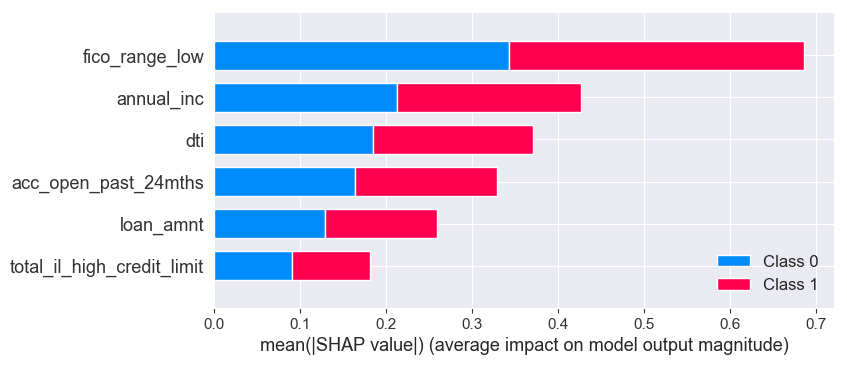

In [86]:
global_shap_values = shap.TreeExplainer(boosted_trees).shap_values(test_features)
shap.summary_plot(global_shap_values, test_features)


In [74]:
# set up the explainer, and adjust the additive attribution intercept to be
# the average over a larger set of predictions
boosted_trees_explainer = shap.KernelExplainer(lambda x: boosted_trees.predict_proba(x)[:, 1],
                                               background_data)
boosted_trees_intercept = predict(boosted_trees, test_input_sample).mean()
boosted_trees_explainer.fnull = np.array([boosted_trees_intercept])
boosted_trees_explainer.expected_value = boosted_trees_explainer.fnull

def get_shap_values(explainer, inputs, n_features=50, n_samples=int(5e3)):
    phi_ndarray = explainer.shap_values(inputs, 
                                        l1_reg=f'num_features({n_features})', 
                                        nsamples=n_samples)[0]
    return sorted_by_abs(pd.Series(phi_ndarray, index=inputs.columns), ascending=False)

In [75]:
shap_values = get_shap_values(boosted_trees_explainer, model_inputs.to_frame().T)
shap_adj = shap_values.sum()
pred = boosted_trees_intercept + shap_adj

In [76]:
shap_values.head(25)

loan_amnt                     0.064242
acc_open_past_24mths         -0.042799
dti                           0.031850
annual_inc                    0.015804
fico_range_low                0.002742
total_il_high_credit_limit   -0.001462
dtype: float64

In [77]:
explanation_df = pd.concat([example_features, model_inputs, shap_values], axis=1, sort=True).loc[shap_values.index[:10]]
explanation_df.columns = ['Corresponding raw input', 'Transformed Feature input', 'SHAP Feature Impact']
explanation_df.index.name = 'Top factors'
display(explanation_df)

,Corresponding raw input,Transformed Feature input,SHAP Feature Impact
Top factors,,,
loan_amnt,30000.00,2.163392,0.064242
acc_open_past_24mths,3.00,-0.570206,-0.042799
dti,28.55,1.194965,0.031850
annual_inc,82000.00,0.122543,0.015804
fico_range_low,690.00,-0.083139,0.002742
total_il_high_credit_limit,59722.00,0.473021,-0.001462


## Analysis for Boosted Tree + SHAP Explanation
As one can see in this case, the loan rejection for this user can be explained by the following. 

The top-2 factors driving his loan risk high are:

* Loan Amount of $30,000  is also having a high risk impact.
* Debt to income ration of 28.55 is the second most important factor. 

There is only 1 factor that is reducing the loan risk are:

* He only has 3 accoutns open in the past 24 months, this is is negatively affecting the charged off probability.


# Conclusion

In this study, we found that Boosted Trees are more accurate than Logistic Regression. Both models support some global feature importance, we can imfer the local explanation of Logistic Regression. And to explain a blackbox model like Boosted Tree, we need use SHAP to explain an individual case. 

So if we can use Boosted Tree + SHAP, we can get both high accuracy and good explainability. 
